# Train a model with real estate data using XGBoost algorithm

## Import Libraries and Load Dataset

In [518]:
# Install necessary libraries
# !pip install xgboost
# !pip install sagemaker


# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

%matplotlib inline

## Modeling

In [519]:
df_final=pd.read_csv('data/final_dataset.csv')

In [520]:
# Transform data of object type to categories for XGBoost Regressor
categorical_cols = df_final.select_dtypes(include=['object']).columns
df_final[categorical_cols] = df_final[categorical_cols].astype("category")
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905900 entries, 0 to 905899
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   actual_worth          905900 non-null  float64 
 1   trans_group_en        905900 non-null  category
 2   procedure_name_en     905900 non-null  category
 3   property_sub_type_en  905900 non-null  category
 4   property_usage_en     905900 non-null  category
 5   reg_type_en           905900 non-null  category
 6   area_name_en          905900 non-null  category
 7   building_name_en      810793 non-null  category
 8   project_name_en       739254 non-null  category
 9   master_project_en     820768 non-null  category
 10  nearest_landmark_en   745558 non-null  category
 11  nearest_metro_en      668679 non-null  category
 12  nearest_mall_en       665163 non-null  category
 13  rooms_count           905900 non-null  float64 
 14  has_parking           905900 non-nul

### Random split

In [521]:
target_feature = 'actual_worth'

# Log-transform the target
y = np.log1p(df_final[target_feature])  # log1p for log(1 + x) to safely handle 0

# Prepare features
X = df_final.drop([target_feature], axis=1)

# Log-transform the 'area' feature
if 'procedure_area' in X.columns:
    X['procedure_area'] = np.log1p(X['procedure_area'])
else:
    raise KeyError("'procedure_area' feature not found in the dataset")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 50% for testing and 50% for validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state=42) 


### Train the model

In [533]:
# XGBoost requires categorical data to be either encoded as integers or passed with enable_categorical=True

model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,    # step size shrinkage
    max_depth=15,         # tree depth (controls complexity)
    n_estimators=100,     # maximum trees (with early stopping)
    eval_metric='rmse',   # optimize RMSE
    early_stopping_rounds=10,
    enable_categorical=True,
    reg_alpha=1, reg_lambda=1,  # L1/L2 regularization
    random_state=42
)

model.fit(X_train,y_train,
           eval_set=[(X_train,y_train),(X_val,y_val)],
           verbose=False)

# Evaluate the model
score = model.score(X_test, y_test)
print("Model Score:", score)

Model Score: 0.9553318692650803


### Evaluate Model Performance

In [528]:
eval_result = model.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

In [529]:
print("Best iteration:", model.best_iteration)
print("Best validation RMSE:", model.best_score)

train_rmse_at_best = model.evals_result()['validation_0']['rmse'][model.best_iteration]
val_rmse_at_best = model.evals_result()['validation_1']['rmse'][model.best_iteration]

print("Train RMSE at best:", train_rmse_at_best)
print("Val RMSE at best:", val_rmse_at_best)
print("RMSE gap:", val_rmse_at_best - train_rmse_at_best)


Best iteration: 99
Best validation RMSE: 0.1706784588644163
Train RMSE at best: 0.15580737802147704
Val RMSE at best: 0.1706784588644163
RMSE gap: 0.014871080842939255


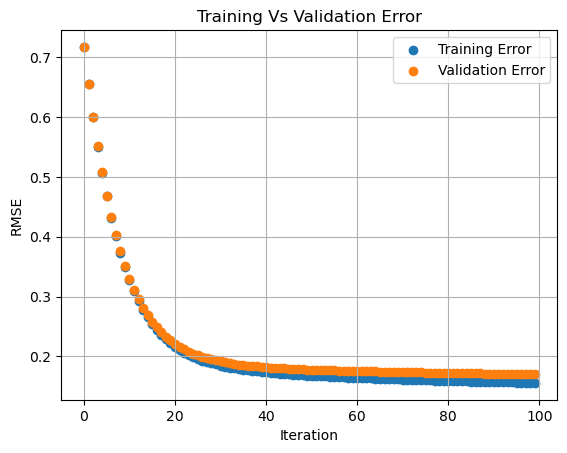

In [530]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

## Hyperparameter tuning

We will perform hyperparameter tuning with RandomizedSearchCV.

- We will use broad parameter distributions (like stats.uniform, stats.randint) to explore the hyperparameter space efficiently.

- This helps identify the general region where good parameters lie, especially for expensive models like XGBoost.

### Hyperparameter tuning with **RandomizedSearchCV**

In [531]:
# Fixed parameters (will not be tuned)
fixed_params = dict(
    objective='reg:squarederror',
    eval_metric='rmse',
    enable_categorical=True,
    tree_method='hist',
    colsample_bytree=0.5,
    random_state=42,
)


# Parameters to tune
param_dist = {
    'max_depth': stats.randint(10, 25),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 1),
    'n_estimators': stats.randint(50, 200),
    'reg_alpha': [0, 1, 5],
    'reg_lambda': np.logspace(0, 2, 5),
}

# Create the XGBoost model object with default parameters
xgb_model = XGBRegressor(**fixed_params)

# Create the RandomizedSearchCV object
randomized_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=0,
    n_jobs=-1,
    n_iter=50,
    random_state=42
)

# Fit the RandomizedSearchCV object to the training data
randomized_search.fit(X_train, y_train)

print("Best params from CV:", randomized_search.best_params_)
print("Best CV RMSE:", -randomized_search.best_score_)
# Best params from CV: {'learning_rate': 0.052754101835854966, 'max_depth': 19, 'n_estimators': 173, 'reg_alpha': 0, 'reg_lambda': 10.0, 'subsample': 0.5314291856867343}
# Best CV RMSE: 0.1695148565901082

Best params from CV: {'learning_rate': 0.10401334424577784, 'max_depth': 18, 'n_estimators': 142, 'reg_alpha': 1, 'reg_lambda': 3.1622776601683795, 'subsample': 0.9856137535862266}
Best CV RMSE: 0.1664579823009499


## Final Model Training and Evaluation

In [532]:
# Retrain on Train + Val
X_fit = pd.concat([X_train, X_val], axis=0)
y_fit = pd.concat([y_train, y_val], axis=0)

# Define XGBoost Regressor model
model = XGBRegressor(**randomized_search.best_params_, **fixed_params)
model.fit(X_fit, y_fit, verbose=False)

# Predict on test
y_pred_log = model.predict(X_test)

# Metrics on log scale
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2_log = r2_score(y_test, y_pred_log)
mae_log = mean_absolute_error(y_test, y_pred_log)

# Adjusted R²
n = X_test.shape[0]  # number of observations
p = X_test.shape[1]  # number of predictors
adj_r2_log = 1 - (1 - r2_log) * (n - 1) / (n - p - 1)

print(f"Test RMSE (log scale): {rmse_log:.6f}")
print(f"Test MAE  (log scale): {mae_log:.6f}")
print(f"Test R²   (log scale): {r2_log:.6f}")
print(f"Test Adjusted R² (log scale): {adj_r2_log:.6f}")

# Metrics in original units
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_log)

rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2_orig = r2_score(y_test_orig, y_pred_orig)
mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
adj_r2_orig = 1 - (1 - r2_orig) * (n - 1) / (n - p - 1)

print(f"Test RMSE (original units): {rmse_orig:,.4f}")
print(f"Test MAE  (original units): {mae_orig:,.4f}")
print(f"Test R²   (original units): {r2_orig:.6f}")
print(f"Test Adjusted R² (original units): {adj_r2_orig:.6f}")
# Test RMSE (log scale): 0.163699
# Test MAE  (log scale): 0.097152
# Test R²   (log scale): 0.956117
# Test Adjusted R² (log scale): 0.956106
# Test RMSE (original units): 464,881.7139
# Test MAE  (original units): 162,977.6255
# Test R²   (original units): 0.944976
# Test Adjusted R² (original units): 0.944962

Test RMSE (log scale): 0.160527
Test MAE  (log scale): 0.094364
Test R²   (log scale): 0.957801
Test Adjusted R² (log scale): 0.957791
Test RMSE (original units): 447,841.3158
Test MAE  (original units): 158,213.8703
Test R²   (original units): 0.948936
Test Adjusted R² (original units): 0.948923


### Feature Importance Evaluation

In [534]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

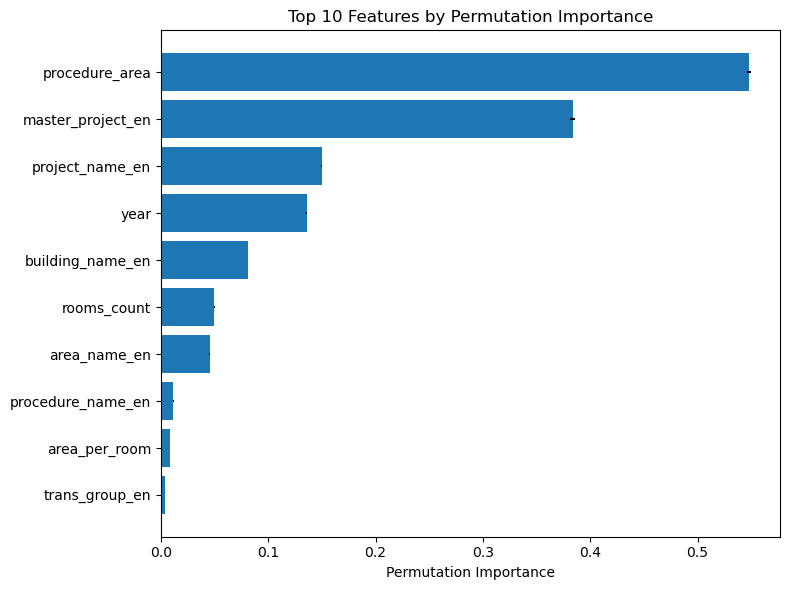

In [535]:
importances = result['importances_mean']
std = result['importances_std']
feature_names = X_test.columns

sorted_idx = importances.argsort()[::-1]

top_n = 10
sorted_idx = sorted_idx[:top_n]

plt.figure(figsize=(8, 6))
plt.barh(range(top_n), importances[sorted_idx], xerr=std[sorted_idx], align='center')
plt.yticks(range(top_n), feature_names[sorted_idx])
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.title(f"Top {top_n} Features by Permutation Importance")
plt.tight_layout()
plt.show()


### Make predictions and evaluate the model

In [536]:
df = pd.DataFrame({'y_test': y_test.reset_index(drop=True), 
                   'y_pred': y_pred_log.round(2), 
                   'y_test_orig': y_test_orig.reset_index(drop=True).astype(int),
                   'y_pred_orig': y_pred_orig.round(2).astype(int),
                   })
print(df.head())

      y_test  y_pred  y_test_orig  y_pred_orig
0  14.758950   14.73      2568799      2484454
1  14.446783   14.44      1880000      1872629
2  14.132526   13.89      1373022      1082658
3  13.262127   13.23       575000       555359
4  14.078441   14.09      1300735      1321865


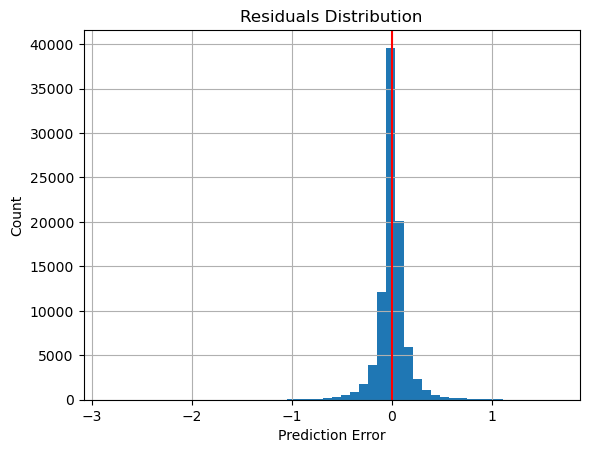

In [537]:
# Test Data Residuals
residuals = (df['y_test'] - df['y_pred'])


plt.hist(residuals,bins=50)
plt.grid(True)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='r')
plt.show()

**Observation:**

The residuals are centered, symmetric, and not heavily skewed.
This is a strong diagnostic indicating that your model generalizes well on the test data.

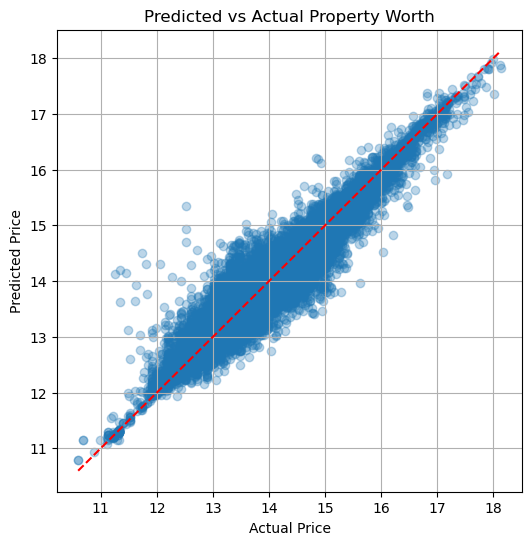

In [538]:
plt.figure(figsize=(6, 6))
plt.scatter(df['y_test'], df['y_pred'], alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Property Worth")
plt.grid(True)
plt.show()

In [539]:
value_counts = (residuals > 0).value_counts(sort=False)
print(' Under Estimation: {0:.2f}'.format(value_counts[True]/len(residuals)))
print(' Over  Estimation: {0:.2f}'.format(value_counts[False]/len(residuals)))

 Under Estimation: 0.50
 Over  Estimation: 0.50


**MAPE**

Given the wide range of property prices, a percentage error will contextualize performance relative to property value

In [540]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero
    mask = y_true != 0
    y_true_nonzero = y_true[mask]
    y_pred_nonzero = y_pred[mask]
    
    mape = np.mean(np.abs((y_true_nonzero - y_pred_nonzero) / y_true_nonzero)) * 100
    return mape

mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
mape

9.811774176455188

The near-even split means the errors are more about random noise than systematic bias

**Observation:**

Tight diagonal cluster:
- The points are densely packed around the red line (y = x), which means:

    - Most predictions are very close to the actual values.

    - The model captures the core pricing patterns effectively.

Slight dispersion at the extremes:
- For very high-priced properties (right side), predictions tend to be underestimated (points fall below the red line).

- For some lower-priced properties, there's slight overprediction.

- This is common in real estate models due to nonlinear price drivers (e.g., luxury effects, rare features, or poor representation of outliers in training data).

Minimal outliers:
- A few scattered points far from the line (e.g., top-left or bottom-right) indicate hard-to-predict properties, but they’re rare.

## Save Model

In [ ]:
model.save_model("dubai_xgb_model.json")

**Conclusion:**

The model could be used as a starting point for pricing discussions. While 94% of variance explained is very high (prices are notoriously hard to predict that well), there will always be unknown factors (interior quality, specific buyer preferences) that introduce noise. This means that a model, however good, has limitations in a real-world application.It is not 100% accurate, but it’s capturing the main drivers of price – which is often the best we can do in data-driven valuation